# Project: Investigate high 

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> This dataset contains information about 10,000 movies collected from The Movie Database (TMDb). The dataset includes information such as genres, budget, revenue, etc. This analysis will take a look at what movie charactertics are most commonly associated with a high return on investment (revenue/budget both adjusted for inflation). More specifically, it will investigate the relationship between a movie's genre, vote_average, and budget on ROI. 

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

> In this section we'll load & inspect our data and determine what (if any) cleaning needs to be applied.

### General Properties

In [122]:
#limits the import to just the columns that we're interested in exploring
df = pd.read_csv("movies.csv", usecols=["genres", "vote_average", "budget_adj", "revenue_adj"])

In [123]:
df.shape

(10866, 4)

In [124]:
#The genres are separated by a | that will need to be cleaned later for proper analysis
df.head()

,genres,vote_average,budget_adj,revenue_adj
0,Action|Adventure|Science Fiction|Thriller,6.5,1.379999e+08,1.392446e+09
1,Action|Adventure|Science Fiction|Thriller,7.1,1.379999e+08,3.481613e+08
2,Adventure|Science Fiction|Thriller,6.3,1.012000e+08,2.716190e+08
3,Action|Adventure|Science Fiction|Fantasy,7.5,1.839999e+08,1.902723e+09
4,Action|Crime|Thriller,7.3,1.747999e+08,1.385749e+09


In [125]:
#193 duplicates
sum(df.duplicated())

1646

In [126]:
#23 null genres, 1030 null production companies. 
df.isnull().sum()

genres          23
vote_average     0
budget_adj       0
revenue_adj      0
dtype: int64

In [127]:
#~7,0000 records have a budget or revenue value of $0. We're going to assume that a $0 value
#means that the data is missing
df.query('budget_adj == 0 or revenue_adj == 0').count()

genres          6988
vote_average    7011
budget_adj      7011
revenue_adj     7011
dtype: int64

In [128]:
#All columns have the correct types for this analysis
df.dtypes

genres           object
vote_average    float64
budget_adj      float64
revenue_adj     float64
dtype: object

### Data Cleaning
> From our exploration above, we've discovered three different modifications that need to be made to our dataset.
1. Drop all our all duplicate rows 
2. Drop rows with null values
3. Drop rows with zero dollar budgets or revenue (which we're going to assume means its missing)
4. Create new dataframes for breaking out the genre and production companies 

In [129]:
# Addresses (1) & (2) & (3)
df.drop_duplicates(inplace=True)
df.dropna(axis = 0, inplace=True)
df = df.query('budget_adj != 0 and revenue_adj != 0')

In [130]:
# Addresses (4) by creating two new dataframes that split out the genre values

# credit for the below two functions: https://gist.github.com/jlln/338b4b0b55bd6984f883
def splitDataFrameList(df,target_column,separator):
    new_rows = []
    df.apply(splitListToRows,axis=1,args = (new_rows,target_column,separator))
    new_df = pd.DataFrame(new_rows)
    return new_df

def splitListToRows(row,row_accumulator,target_column,separator):
    split_row = row[target_column].split(separator)
    for s in split_row:
        new_row = row.to_dict()
        new_row[target_column] = s
        row_accumulator.append(new_row)

df_genres = splitDataFrameList(df, 'genres', '|')

In [131]:
#remove unncessary columns from dataframes
df.drop(['genres'], axis=1, inplace=True)
df_genres.drop(['vote_average'], axis=1, inplace=True)

In [132]:
df_genres.head()

,budget_adj,genres,revenue_adj
0,1.379999e+08,Action,1.392446e+09
1,1.379999e+08,Adventure,1.392446e+09
2,1.379999e+08,Science Fiction,1.392446e+09
3,1.379999e+08,Thriller,1.392446e+09
4,1.379999e+08,Action,3.481613e+08


<a id='eda'></a>
## Exploratory Data Analysis


### Which genres have the highest roi?

In [133]:
#Check sample size
df_genres.groupby(['genres']).count()['revenue_adj']

genres
Action             1085
Adventure           749
Animation           201
Comedy             1358
Crime               651
Documentary          35
Drama              1756
Family              425
Fantasy             396
Foreign              13
History             129
Horror              463
Music               136
Mystery             344
Romance             667
Science Fiction     519
TV Movie              1
Thriller           1204
War                 119
Western              52
Name: revenue_adj, dtype: int64

In [134]:
#Drop TV movie & foreign genres to due to smaller sample size. I chose 25 as the somewhat arbitrary cutoff
df_genres = df_genres.query('genres != "TV Movie" and genres != "Foreign"')

Text(0.5,0,'ROI')

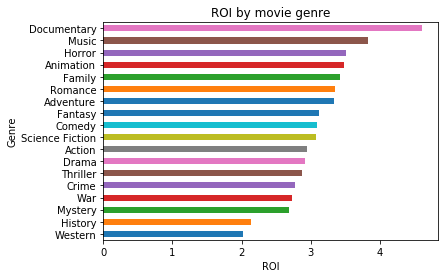

In [135]:
df_genres_roi = df_genres.groupby(['genres']).sum()['revenue_adj']/df_genres.groupby(['genres']).sum()['budget_adj']
df_genres_roi.sort_values().plot.barh()
plt.title('ROI by movie genre')
plt.ylabel("Genre")
plt.xlabel("ROI")

### What relationship does a movie's budget size have on ROI?

In [136]:
df['roi'] = df['revenue_adj']/df['budget_adj']

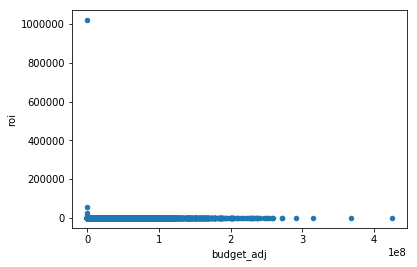

In [137]:
#Plot initial dataset
df.plot(x='budget_adj', y='roi', kind='scatter')

Text(0.5,0,'Budget Adjusted for Inflation')

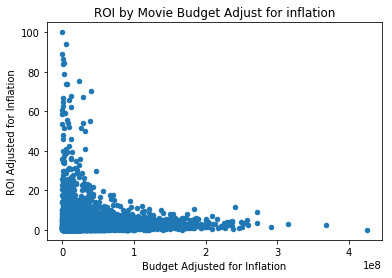

In [138]:
# There are quite a few outliers that make visualizing this difficult. We remove any movie with over a 100x ROI from
# the dataset.
df = df.query('roi <= 100')
df.plot(x='budget_adj', y='roi', kind='scatter')
plt.title('ROI by Movie Budget Adjust for inflation')
plt.ylabel("ROI Adjusted for Inflation")
plt.xlabel("Budget Adjusted for Inflation")

### What relationship does a movie's average voting score have on ROI?

Text(0.5,0,'Vote Average')

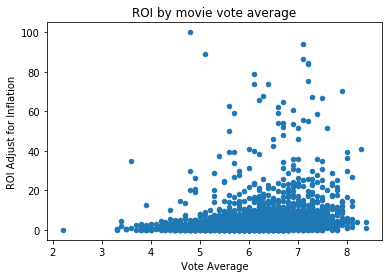

In [139]:
df.plot(x='vote_average', y='roi', kind='scatter')
plt.title('ROI by movie vote average')
plt.ylabel("ROI Adjust for Inflation")
plt.xlabel("Vote Average")

## Conclusions

> Below is a summary of some thoughts based on our research questions and subsequest analysis posed above. Please keep in mind that all of the findings below are tentative and not conclusive.

> Which genres have the highest roi? -- There appears to be some difference in ROI among different movie genres. Our highest ROI genre has a ~100% better ROI and our worst two performing genres. Note: these measures could be skewed due to outliers. If we were to analyze this relationship further, it'd be interesting to control for budget & voting average (our two variable explored below).

> What relationship does a movie's budget size have on ROI? -- There appears to be an negative correlation between a movie's budget and its ROI. All of the movies with 30x+ ROI are on the lower end of the budget axis and all of the movies on the higher end of the budget axis have below a 10x ROI. It's likely the case that movies with high budgets are unlikely to have an extraordinarily high ROI because it would require them to receive an almost unrealistic amount of demand. The reverse is true of movies with low budgets. Althouhg it is very unlikely for them to hit a 30x+ return it is realistic given the size of the movie market.

> What relationship does a movie's average voting score have on ROI? -- There looks to be a positive correlation between a movie's vote average and its ROI. We see a much larger number of movies with a 15x+ ROI having a vote average in the 6+ range. It inuitively make sense that these might be correlated given that a movie that user's perceive to be of high quality adds more of an incentive to go watch the movie in theatres.